<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/master/FixedModelAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 6.5MB 20.5MB/s 
     |████████████████████████████████| 25.9MB 1.5MB/s 
     |████████████████████████████████| 256kB 36.2MB/s 
     |████████████████████████████████| 2.7MB 45.5MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=b67db37f9f1b9eb44f241fc32bc5283957a8d330d37b75696ea764eeb02e4a70
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=53a7dc582cf8fdcba7683dec5a97e0f3bbd8971c548f2117f5158aa8a8b21663
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=9d3ed05c652cf224d0e579a1518496c601306b54a9d1823a5fcbdf8085107e84
  Stored in directory: /root/.cache/pip/wheels

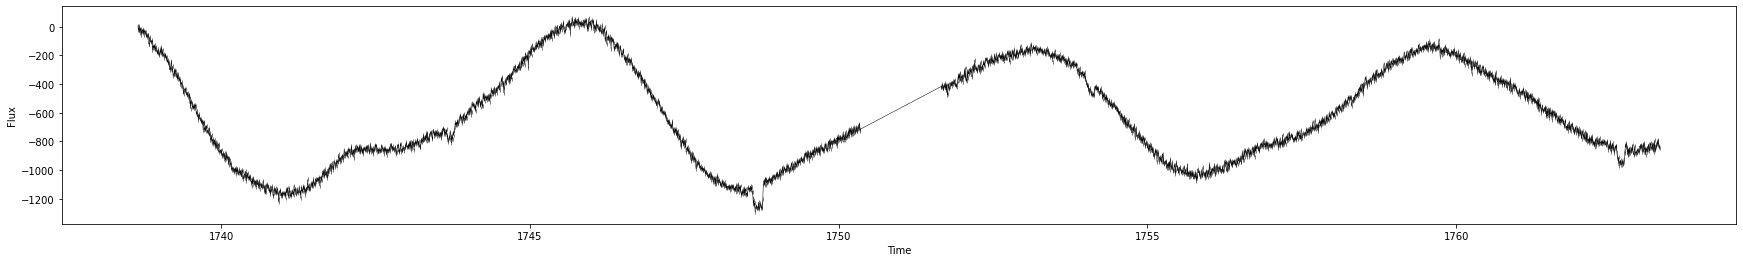

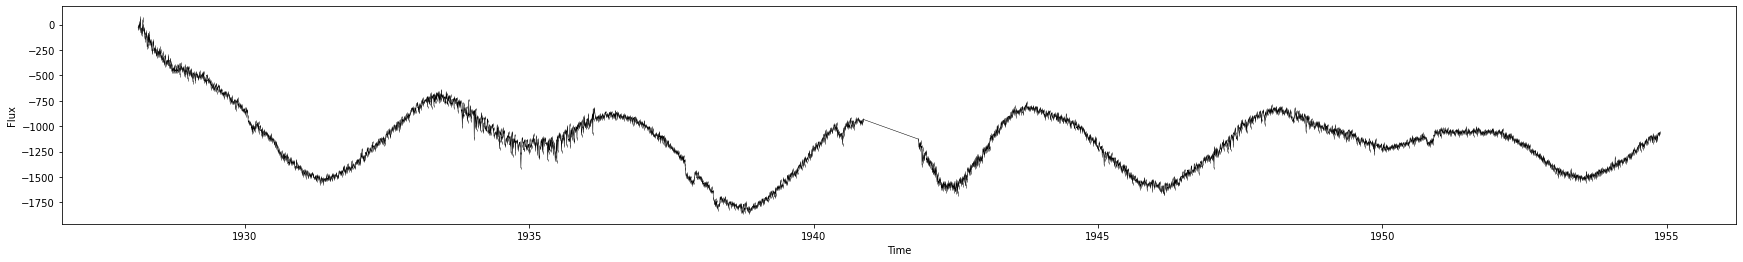

In [9]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
%matplotlib inline

flags = lk.utils.TessQualityFlags
q = flags.CoarsePoint | flags.Desat | flags.Argabrightening

tpfs = lk.search_targetpixelfile("TIC 27491137").download_all(quality_bitmask=q)

clcs = []
for tpf in tpfs:
    breaks = np.where(np.append(False, np.diff(tpf.time) > (np.median(np.diff(tpf.time)) * 5)))[0]
    aper = tpf.create_threshold_mask()


    lc = tpf.to_lightcurve()

    # Scattered light
    bkg = tpf.get_bkg_lightcurve(tpf.pipeline_mask)
    bkg[~np.isfinite(lc.flux_err)].flux *= 0
    lc += bkg
    lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

    bkg = tpf.flux_bkg
    bkg[~np.isfinite(bkg)] = 0
    pixels = (tpf.flux + bkg)[:, ~aper]
    dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).split(list(breaks)).append_constant()
    
    # centroids
    t = (lc.cadenceno - np.median(lc.cadenceno))/(len(lc.time))
    ts = np.vstack([((tpf.time - t[0])/(t[-1] - t[0]) - 0.5) * np.in1d(tpf.time, t) for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p1 = np.vstack([np.nan_to_num(tpf.pos_corr1) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p2 = np.vstack([np.nan_to_num(tpf.pos_corr2) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    pdm = lk.DesignMatrix(np.hstack([ts, ts**2, p1, p2, p1*p2, p1**2*p2, p1*p2**2, p1**2*p2**2]), name = 'poscorrs')
    pdm.prior_sigma = np.ones(pdm.shape[1]) * 0.01


    spline = lk.designmatrix.create_spline_matrix(lc.time, n_knots=80)

    dm = lk.DesignMatrixCollection([dm1, pdm, spline])

    # First iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10)

    # YOU SHOULD REPLACE THIS HACKY MASK WITH A BETTER ONE.
    a = (clean_lc).bin(10).flatten(81)
    _, m = a.remove_outliers(2, return_mask=True)
    m = (convolve(m, Box1DKernel(10)) > 0.5)
    mask = np.interp(clean_lc.time, a.time, m) > 0
    mask = convolve(mask, Box1DKernel(5)) > 0

    # second iteration
    r = lk.RegressionCorrector(lc)
    _ = r.correct(dm, sigma=1e10)
    corr = (r.diagnostic_lightcurves['poscorrs'] + r.diagnostic_lightcurves['pixels'])
    clean_lc = (lc - corr)

    clean_lc = lk.LightCurve(np.asarray(clean_lc.time, np.float64),
                         np.asarray(clean_lc.flux, np.float64),
                         np.asarray(clean_lc.flux_err, np.float64))

    fig, ax = plt.subplots(figsize=(30, 4))
    (clean_lc).bin(5, method='median').errorbar(ls='-', ax=ax, c='k')
    
    clcs.append(clean_lc)

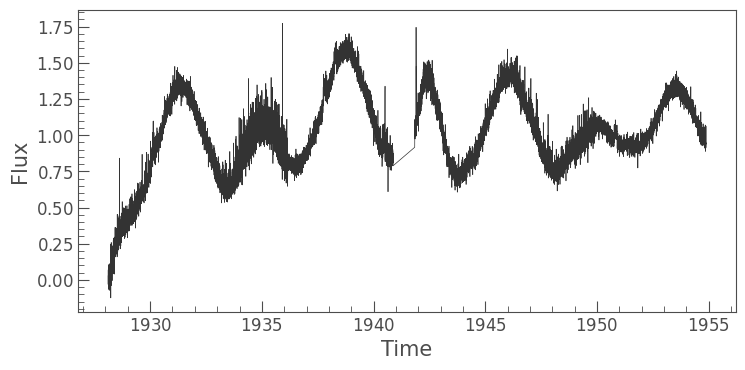

In [112]:
clean_lc.plot()

In [6]:
lc = lk.LightCurveCollection(clcs).stitch()

/usr/local/lib/python3.6/dist-packages/lightkurve/lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


In [ ]:
clc[32000:32950].plot()

In [ ]:
#Creating a mask to mask out second super Earth (SE) planet transits
#(This is done initially to make fitting of the first SE much easier, we will then fit for just SE2 and finally combine)
mask1 = (clc.time < 1762.4) | (clc.time > 1762.8) 
m1lc = clc[mask1]
mask2 = (m1lc.time < 1938.1)| (m1lc.time > 1938.44) 
lc =  m1lc[mask2]

fig, ax = plt.subplots(figsize=(30, 4))
lc.plot(ax=ax, label='lc')
plt.xlim(1738.5, 1764)

fig, ax = plt.subplots(figsize=(30, 4))
lc.plot(ax=ax, label='lc')
plt.xlim(1928, 1955)

In [ ]:
lc.flux.shape

(33453,)

In [ ]:
import theano.tensor as tt
masks = [tt.as_tensor(np.in1d(np.arange(len(lc.flux)), np.arange(a, b)).astype(float)) for a, b in zip([3000, 6800, 9500, 17500, 23100, 25000, 31000], [4200, 7688, 10800, 18500, 23700, 25700, 33000])]

dips = [(lc/mask.eval())[np.isfinite(1/mask.eval())] for mask in masks]

In [ ]:
##### NEW MODEL #####


import pymc3 as pm
import exoplanet as xo
from exoplanet.gp import terms, GP
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=0.01)

    #sigma and rho for the GP
    log_sigma = pm.Uniform("log_sigma", lower=-10, upper=10)
    log_rho = pm.Uniform("log_rho", lower=-10, upper=10)

    # Set up the kernel and GP
    # The kernel is defining the covariance matrix for the GP
    kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)
    # I think this next step forms the gp.compute function required as a prerequisite to gp.pred later
    gp = GP(kernel, lc.time, lc.flux_err **2)
    
    # Stellar variables
    r_star = pm.Normal("r_star", mu=0.772148, sd=0.0454673, testval=0.78)    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval=0.87)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    ####### SETTING UP TRANSITS #######

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=np.array([1743.72, 1748.69, 1762.69]), sd=0.5, shape=3)

    # The log period; also tracking the period itself
    #logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Uniform("period", lower=1, upper=200, testval=np.array([10.3, 33, 50]), shape = 3)

    r = pm.Uniform("r", lower=0.001, upper=0.1, shape=3, testval=np.array([0.02, 0.039, 0.03]))
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape=3)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=r_star, m_star=m_star)

    #Actual dataset
    t = lc.time

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = lc.flux


    #Condition the GP on the observations and add the marginal likelihood to the model
    gp.marginal("gp", observed=lc.flux - light_curve)

    gp_pred = pm.Deterministic('gp_pred', gp.predict())


    #Optimising variables in stages to see if there is any area with a large precision loss.
    #This is good practise as it helps with debugging and also means we dont sample from a trashy model
    
    map_soln = xo.optimize(start=model.test_point, vars=[log_sigma, log_rho])
    map_soln = xo.optimize(start=map_soln, vars=[t0, mean])
    map_soln = xo.optimize(start=map_soln, vars=[r])
    map_soln = xo.optimize(start=map_soln, vars=[period])
    map_soln = xo.optimize(start=map_soln, vars=[t0, mean, r, period, b, log_sigma, log_rho])

ModelPlot = plt.figure()
plt.plot(t, y, ".k", ms=1, label="data1")
for i, l in enumerate("bcd"):
  plt.plot(t, map_soln["light_curves"][:, i], lw=2, label="planet {0}".format(l))
 # plt.plot(t, map_soln['gp_pred'] + map_soln['mean'], label='gppred')
plt.xlim(1740, 1765)
plt.ylim(-0.0050, 0.0050)
#plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [ ]:
######## OLD MODEL THAT NEEDS CHANGING. KEPT IN FOR REFERENCE ########

with pm.Model() as model:
    mean = pm.Normal("mean", mu=1, sd=0.01)

    log_sigma = pm.Uniform("log_sigma", lower=-10, upper=10)
    log_rho = pm.Uniform("log_rho", lower=-10, upper=10)

    # Set up the kernel and GP
    # The kernel is defining the covariance matrix for the GP
    kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)
    # I think this next step forms the gp.compute function required as a prerequisite to gp.pred later
    gp = GP(kernel, lc.time, lc.flux_err **2)
    


    # Stellar variables
    r_star = pm.Normal("r_star", mu=0.772148, sd=0.0454673, testval=0.78)    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval=0.87)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))


    #Super Earth candidate 1
    tv = 1743.72
    t01 = pm.Uniform("t01", lower=tv-0.1, upper=tv+0.1)
    period1 = pm.Uniform("period1", lower=9, upper=11, testval=10.1)
    r1 = pm.Uniform("r1", lower=0.001, upper=0.1, testval=0.04)
    b1 = xo.distributions.ImpactParameter("b1", ror=r1/r_star)
    orbit1 = xo.orbits.KeplerianOrbit(period=period1, t0=t01, b=b1, r_star=r_star, m_star=m_star) 
    light_curve1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit1, r=r1, t=lc.time)[:, 0] 

    #Uranus sized candidate
    #By working out the time difference between the two dips we know the maximum period is roughly 190 days. 
    #We also know there is only one transit per sector therefore min period is around 27 days.
    tv = 1748.69 
    t02 = pm.Uniform("t02", lower=tv-0.1, upper=tv+0.1)
    period2 = pm.Uniform("period2", lower=27, upper=2000, testval=189)
    r2 = pm.Uniform("r2", lower=0.001, upper=0.1, testval=0.03)
    b2 = xo.distributions.ImpactParameter("b2", ror=r2/r_star)
    orbit2 = xo.orbits.KeplerianOrbit(period=period2, t0=t02, b=b2, r_star=r_star, m_star=m_star) 
    light_curve2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit2, r=r2, t=lc.time)[:, 0] 



    #Spare transit setup, not required for the first runthrough but will be needed for the second 
    #super earth so kept for easy copy pasta!

    tv =  1762.67
    t03 = pm.Uniform("t03", lower=tv-0.1, upper=tv+0.1)
    period3 = pm.Uniform("period3", lower=0, upper=200, testval=175.628)
    r3 = pm.Uniform("r3", lower=0.001, upper=0.1, testval=0.04)
    b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star)
    orbit3 = xo.orbits.KeplerianOrbit(period=period3, t0=t03, b=b2, r_star=r_star, m_star=m_star) 
    light_curve3 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit3, r=r3, t=lc.time)[:, 0] 


    #Model light curve
    light_curve = pm.Deterministic('light_curve', light_curve1 + light_curve2 + light_curve3 + mean)
    
    
    # This was already commented out.

#s    pm.Normal("obs1", mu=light_curve, sd=clean_lc.flux_err, observed=clean_lc.flux)
    
#     # Fit for the maximum a posteriori parameters given the simuated dataset
#     # Posterior distribution is usually given as Prior*Likelihood


     #Condition the GP on the observations and add the marginal likelihood
     #to the model
    gp.marginal("gp", observed=lc.flux - light_curve)

    gp_pred = pm.Deterministic('gp_pred', gp.predict())



    #The following few lines was taken from the old model to include the actual dataset as we are not using the GP
    #y = lc.flux

    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    #pm.Normal("obs", mu=light_curve, sd=lc.flux_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood



  #Optimising variables in stages to see if there is any area with a large precision loss.
  #This is good practise as it helps with debugging and also means we dont sample from a trash model
    
    map_soln = xo.optimize(start=model.test_point, vars=[log_sigma, log_rho])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, mean])
    map_soln = xo.optimize(start=map_soln, vars=[r1, r2])
    map_soln = xo.optimize(start=map_soln, vars=[period1])
    map_soln = xo.optimize(start=map_soln, vars=[period2])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02 , mean, r1, r2, period1, period2, b1, b2, log_sigma, log_rho])

In [ ]:
lc.plot()
plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'])
plt.plot(lc.time, map_soln['light_curve'])

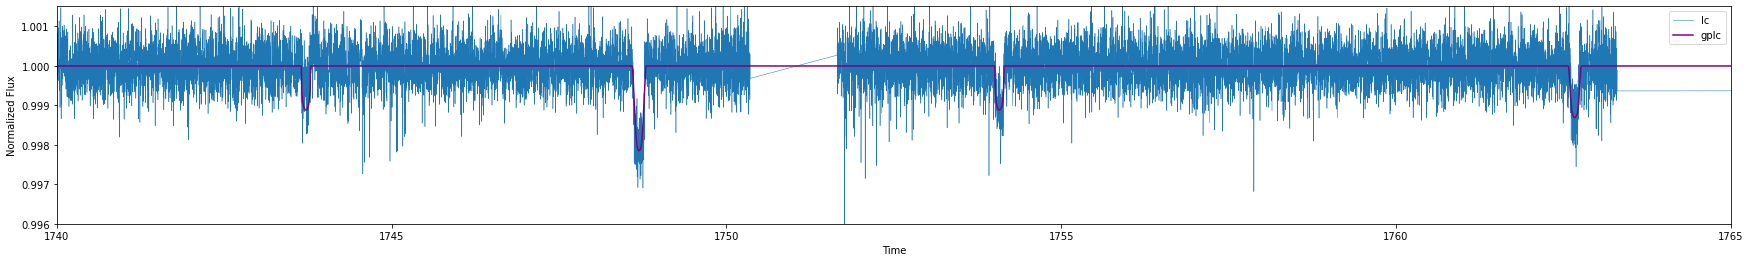

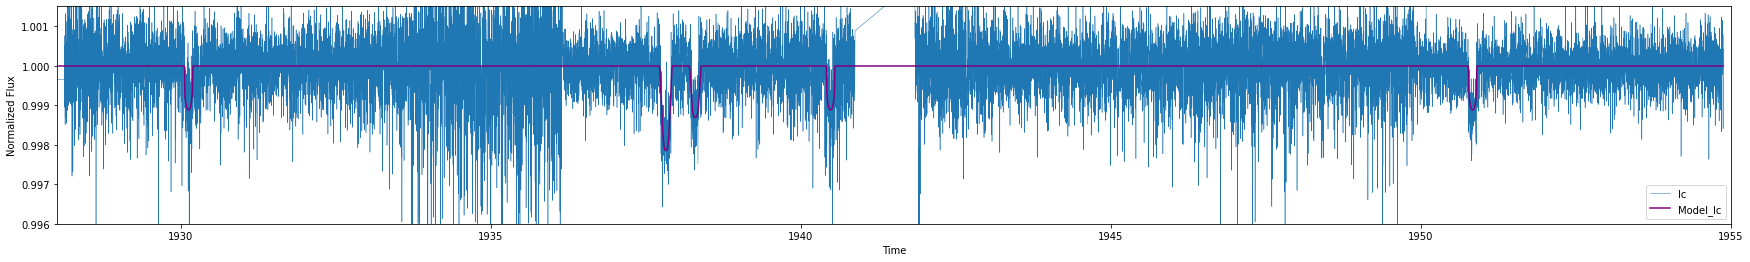

In [21]:
fig, ax = plt.subplots(figsize=(30, 4))
lc.plot(ax=ax, label='lc')
#plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'], label='gppred')
plt.plot(lc.time, map_soln['light_curve'], label='gplc', color='purple')
plt.xlim(1740, 1765)
plt.ylim(0.9960, 1.0015)
plt.legend()

fig, ax = plt.subplots(figsize=(30, 4))
lc.plot(ax=ax, label='lc')
#plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'], label='gppred')
plt.plot(lc.time, map_soln['light_curve'], label='Model_lc', color='purple')
plt.xlim(1928, 1955)
plt.ylim(0.9960, 1.0015)
plt.legend()

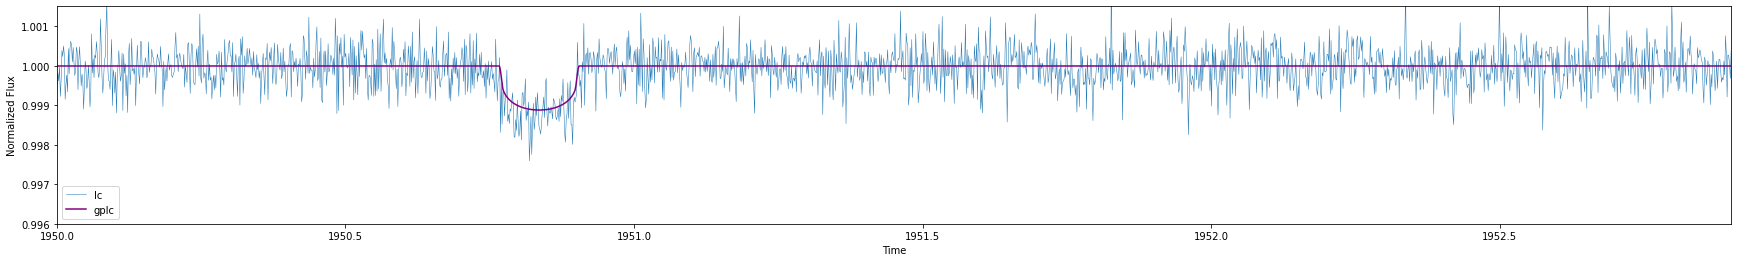

In [109]:
#Used to quickly check strange signal in lc at 1951.75

fig, ax = plt.subplots(figsize=(30, 4))
lc.plot(ax=ax, label='lc')
plt.plot(lc.time, map_soln['light_curve'], label='gplc', color='purple')
plt.xlim(1950, 1952.9)
plt.ylim(0.9960, 1.0015)
plt.legend()

In [107]:
masks = [tt.as_tensor(np.in1d(np.arange(len(lc.flux)), np.arange(a, b)).astype(float)) for a, b in zip([3000, 6800, 9500, 15000, 17300, 23300, 24000, 25300, 31700], [4200, 7688, 10800, 16800, 19000, 24000, 24600, 25900, 34000])]

dips = [(lc/mask.eval())[np.isfinite(1/mask.eval())] for mask in masks]

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


<Figure size 432x288 with 0 Axes>

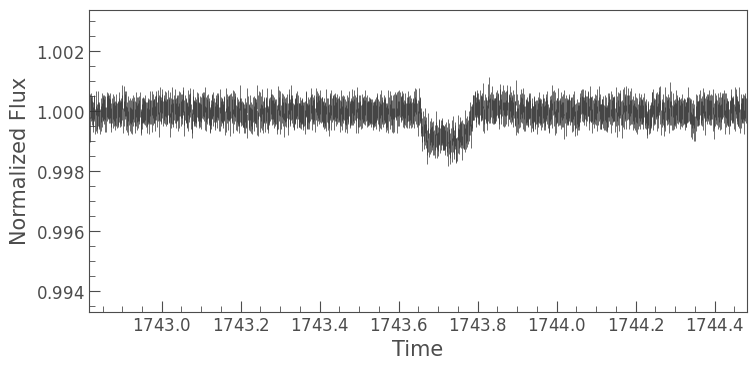

<Figure size 432x288 with 0 Axes>

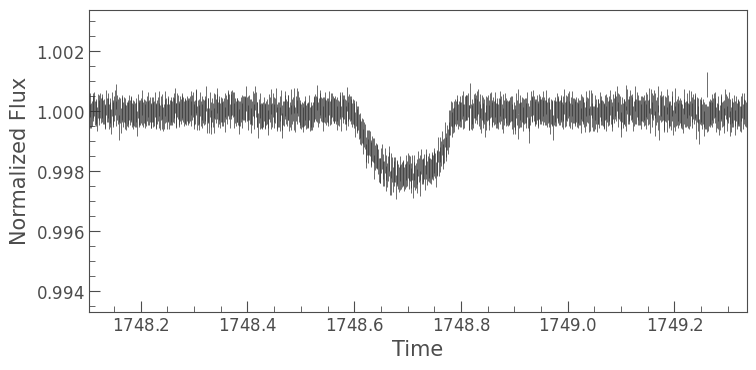

<Figure size 432x288 with 0 Axes>

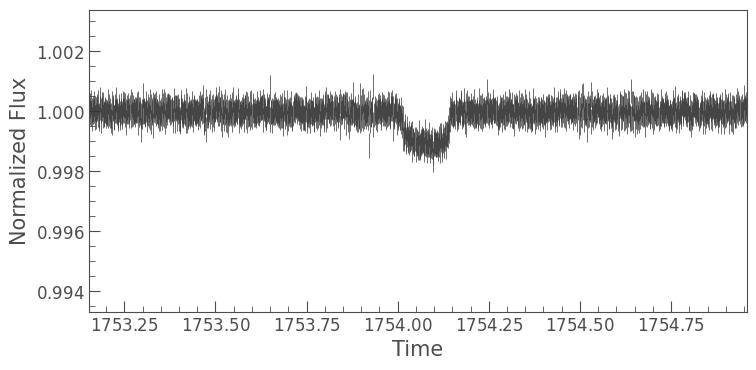

<Figure size 432x288 with 0 Axes>

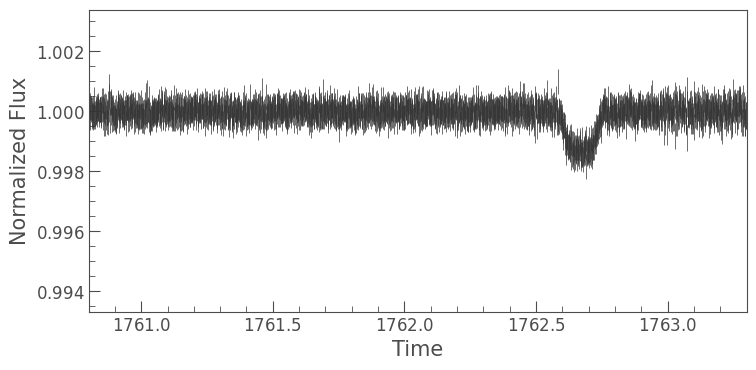

<Figure size 432x288 with 0 Axes>

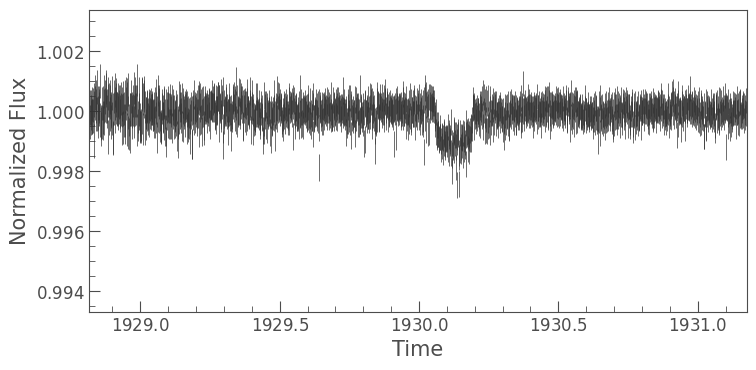

<Figure size 432x288 with 0 Axes>

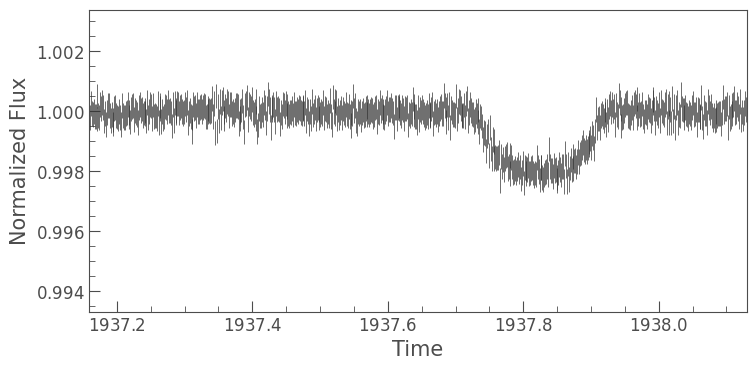

<Figure size 432x288 with 0 Axes>

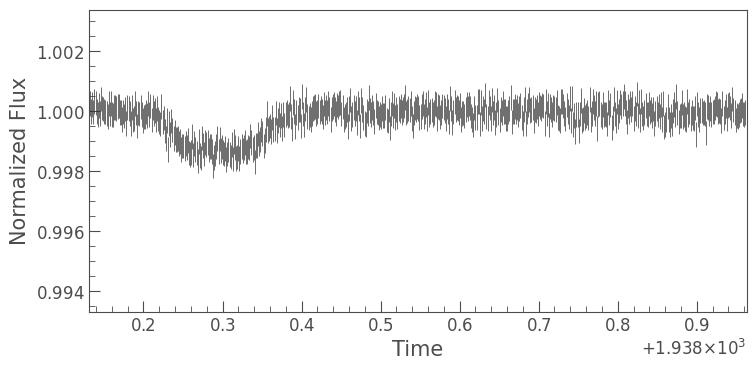

<Figure size 432x288 with 0 Axes>

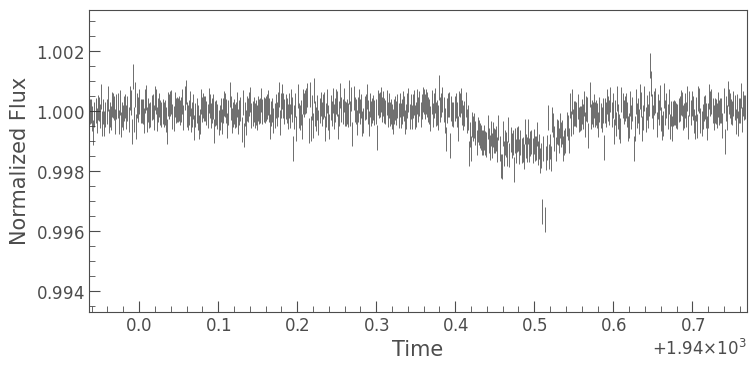

<Figure size 432x288 with 0 Axes>

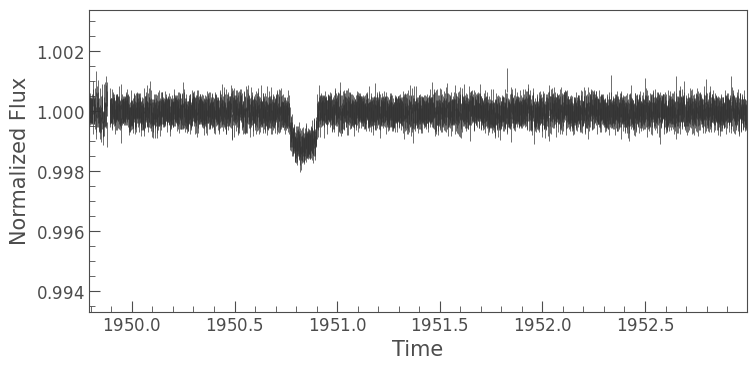

In [108]:
for d in dips:
    plt.figure()
    (lc - (map_soln['gp_pred'])).errorbar()
    plt.xlim(d.time[0], d.time[-1])

In [23]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b3, r3, period3, t03, b2, r2, period2, t02, b1, r1, period1, t01, u, m_star, r_star, log_rho, log_sigma, mean]
Sampling chain 3, 0 divergences: 100%|██████████| 2000/2000 [17:37<00:00,  1.89it/s]
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197

In [24]:
labels = ['t01', 't02', 't03', 'mean',
          'period1', 'period2', 'period3',
          'r1', 'r2', 'r3', 'b1', 'b2', 'b3', 'u']

In [25]:
pm.summary(trace, varnames=labels)

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
t01,1743.721,0.002,1743.718,1743.724,0.000,0.000,5365.0,5349.0,6067.0,2176.0,1.00
t02,1748.696,0.002,1748.692,1748.700,0.000,0.000,4146.0,4128.0,4163.0,1010.0,1.00
t03,1762.669,0.003,1762.663,1762.675,0.000,0.000,4662.0,4662.0,4914.0,2349.0,1.01
mean,1.000,0.000,1.000,1.000,0.000,0.000,4325.0,4325.0,4442.0,2476.0,1.00
period1,10.356,0.000,10.356,10.356,0.000,0.000,4832.0,4832.0,5403.0,2136.0,1.00
period2,189.127,0.003,189.121,189.132,0.000,0.000,4734.0,4734.0,4725.0,2633.0,1.00
period3,175.624,0.006,175.613,175.634,0.000,0.000,4774.0,4774.0,4814.0,2505.0,1.00
r1,0.024,0.001,0.021,0.026,0.000,0.000,2226.0,2167.0,2367.0,1790.0,1.00
r2,0.039,0.002,0.035,0.043,0.000,0.000,3628.0,3558.0,3770.0,2658.0,1.00
r3,0.029,0.002,0.026,0.032,0.000,0.000,3670.0,3605.0,3752.0,2816.0,1.00


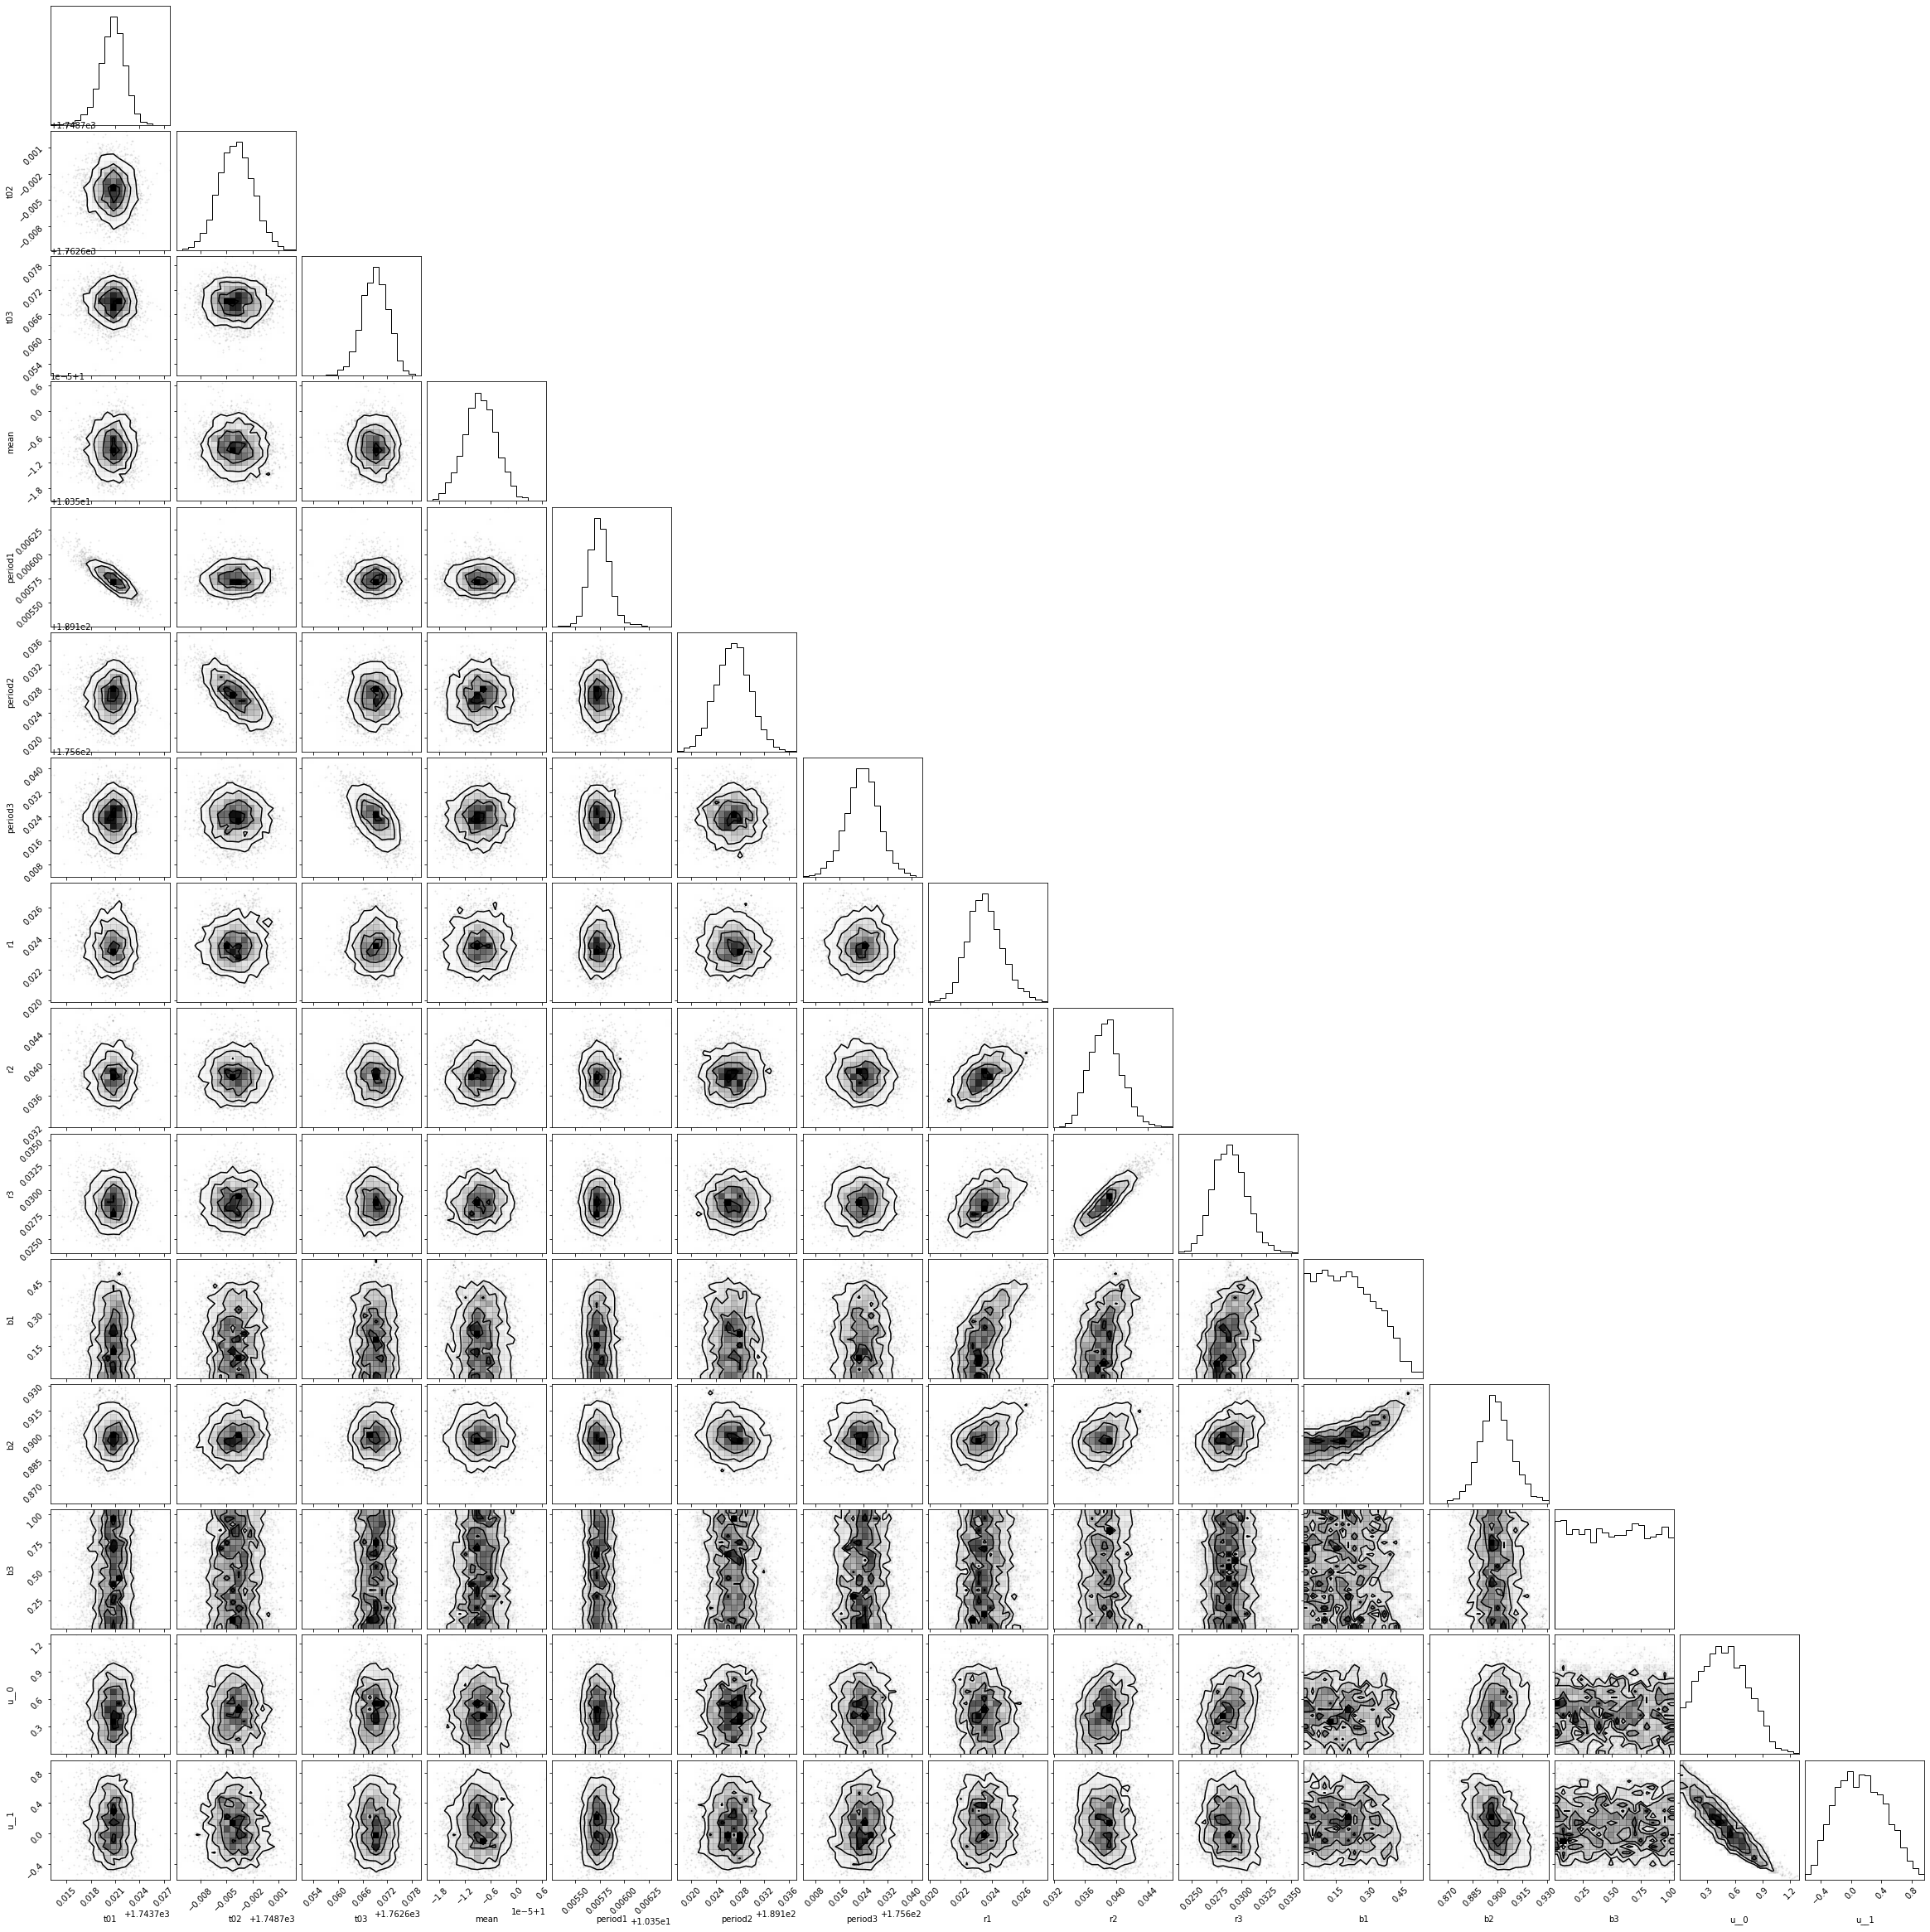

In [26]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=labels)
fig = corner.corner(samples)
fig.savefig('corner.png', dpi=200, bbox_inches='tight')


In [27]:
mu, lower, upper = np.percentile(trace['gp_pred'] + trace['light_curve'], [50, 16, 84], axis=0)

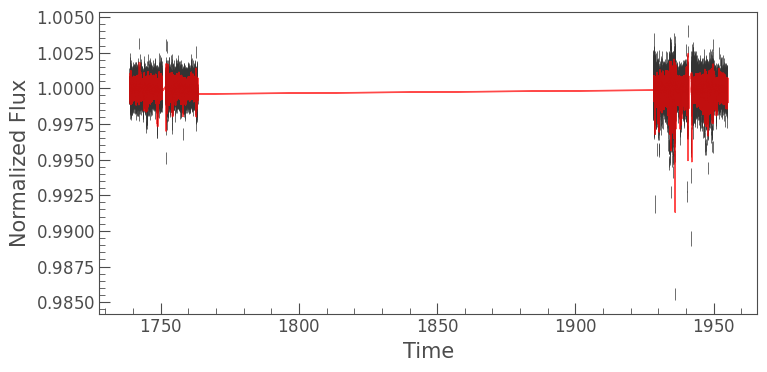

In [28]:
ax = lc.errorbar()
ax.fill_between(lc.time, lower, upper, zorder=10, color='r', alpha=0.7)


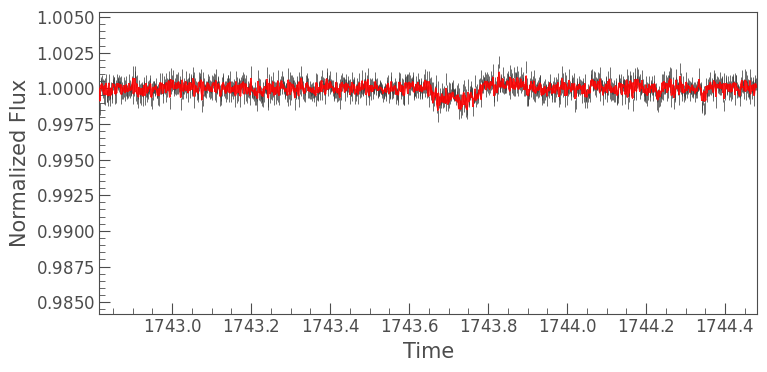

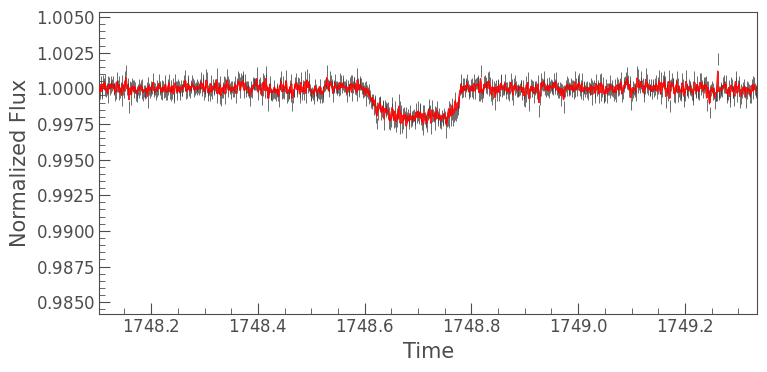

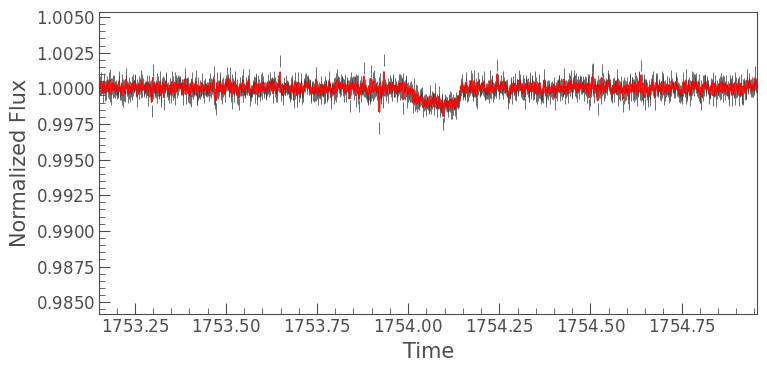

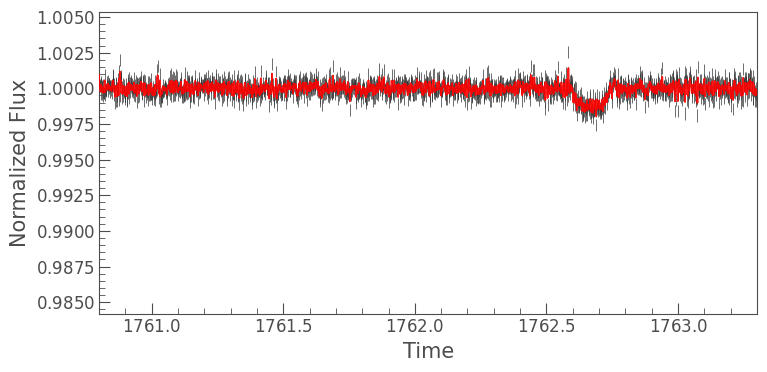

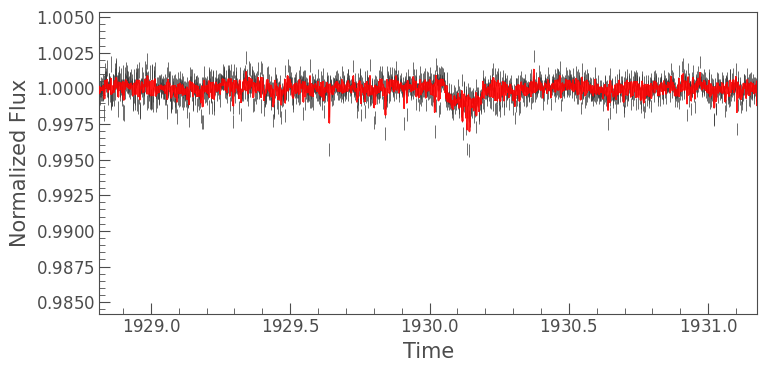

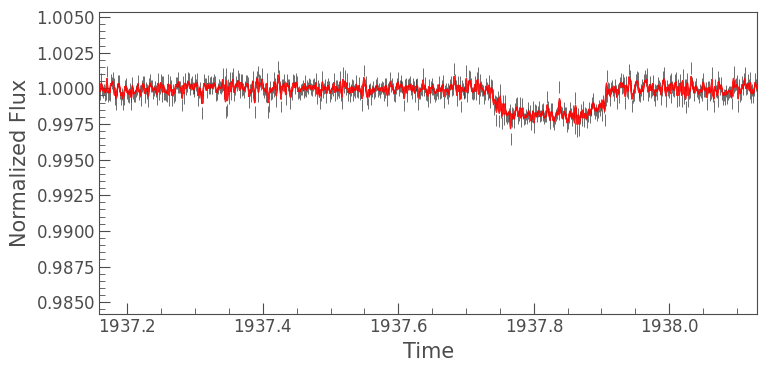

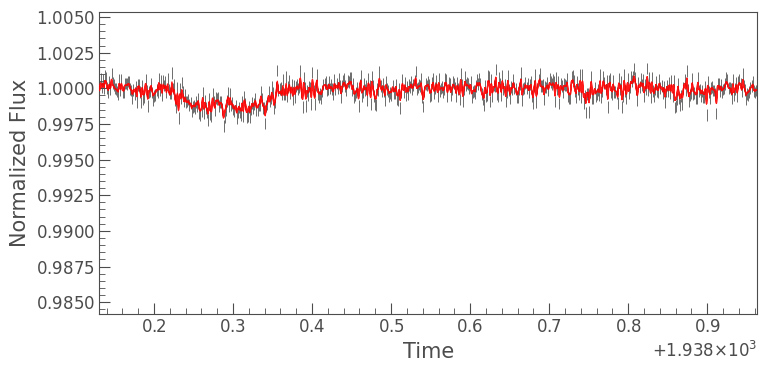

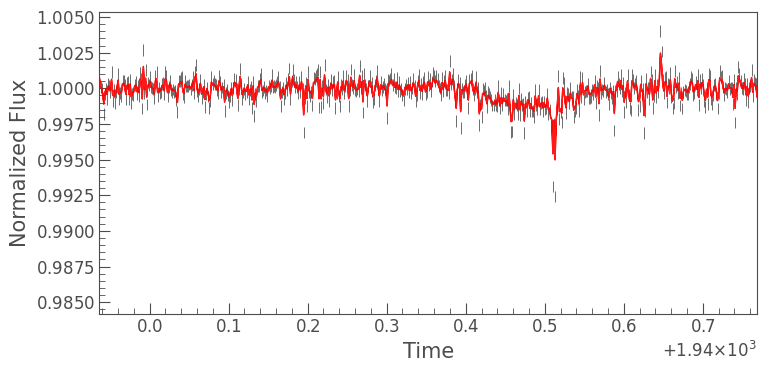

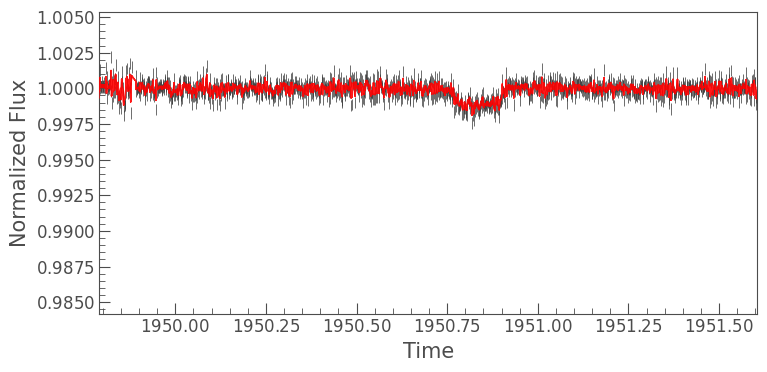

In [98]:
for d in dips:
    ax = lc.errorbar(zorder=-1)
    ax.fill_between(lc.time, lower, upper, zorder=10, color='r', alpha=0.9)
#    ax.plot(clean_lc.time, mu, zorder=10, color='r')

    ax.set_xlim(d.time[0], d.time[-1])

In [99]:
import pandas as pd
pd.DataFrame([np.append([label], np.nanpercentile(trace[label], [50, 16, 84])) for label in labels], columns=['Name', 'Mean', "Lower Percentile", "Upper Percentile"])

,Name,Mean,Lower Percentile,Upper Percentile
0,t01,1743.7206937498127,1743.7190611851101,1743.722106761762
1,t02,1748.696056481016,1748.6941220649942,1748.698043738817
2,t03,1762.6689955507604,1762.6657952771413,1762.6720923095345
3,mean,0.9999914365822551,0.9999876547185077,0.9999952847054963
4,period1,10.355742039686525,10.355645524447283,10.35584715885319
5,period2,189.12683140902834,189.1239271965572,189.12962079992855
6,period3,175.62373953599484,175.61831299499053,175.62903846242773
7,r1,0.023489977242680538,0.022473837471648928,0.024671758992627107
8,r2,0.03856337971282915,0.03651563952558766,0.040678457389230774
9,r3,0.028767594913462265,0.02715308597825102,0.030513096407632105


In [100]:
# SAVE THE MAP SOLUTION
import pickle
pickle.dump(map_soln, open('map_soln.p', 'wb'))

# Make sure it's committed to github somewhere

In [101]:
results = {var:np.percentile(trace[var], [50, 16, 84], axis=-1) for var in trace.varnames}

In [102]:
results

{'b1': array([0.19771038, 0.06418893, 0.35341673]),
 'b1_impact__': array([-1.43754309, -2.7118926 , -0.64957254]),
 'b2': array([0.89882322, 0.88938635, 0.90917383]),
 'b2_impact__': array([1.78610355, 1.71737579, 1.86939199]),
 'b3': array([0.51691472, 0.15646628, 0.86980115]),
 'b3_impact__': array([-0.00640537, -1.72626062,  1.64499324]),
 'gp_pred': array([[ 1.89472594e-05,  1.57643852e-05,  1.63904800e-05, ...,
          1.87654566e-05,  1.44914975e-05,  1.47361062e-05],
        [-3.08122072e-04, -3.11385934e-04, -3.07025487e-04, ...,
         -3.07028124e-04, -3.13839071e-04, -3.14129847e-04],
        [ 3.33607623e-04,  3.30680597e-04,  3.27799808e-04, ...,
          3.32064987e-04,  3.31069499e-04,  3.31601946e-04]]),
 'light_curve': array([[0.99998702, 0.99999173, 0.99999118, ..., 0.99998724, 0.99999338,
         0.99999314],
        [0.99998702, 0.99999173, 0.99999118, ..., 0.99998724, 0.99999338,
         0.99999314],
        [0.99998702, 0.99999173, 0.99999118, ..., 0.99998

In [103]:
pickle.dump(results, open('results.p', 'wb'))

In [104]:
from google.colab import files

#results
filename = "Results.pickle"
outfile = open(filename, "wb")
pickle.dump(results, outfile)
outfile.close()
files.download('Results.pickle')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>